<h1>Chapter 3</h1>

In [87]:
#get the MNIST data set, it is pictures of hand drawn numbers
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False) #scikit makes the MNIST dataset as a dataframe which is NOT what we want
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [88]:
#inspecting the data
X, y = mnist["data"], mnist["target"]

print(X.shape) #data, 70,000 images, each image has 784 features (which are 28x28 pixels)
print(y.shape) #targets

(70000, 784)
(70000,)


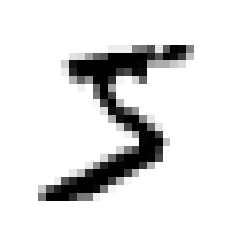

In [89]:
#display 1 digit from dataset
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0] #this is number 5
some_digit_image = some_digit.reshape(28, 28) #reshape to a 28x28 pixel image
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show() #this looks like the number 5

In [90]:
#check what the actual label is for that image
#y is the targets
print(y[0])

#these targets are string to cast to int to ensure itll work with algorithims
import numpy as np
y = y.astype(np.uint8)

5


<h2>Set Test and Training Set</h2>


In [91]:
#X is the data, y is the target
#data is already preshuffled and split for us
#first 60,000 is traing, last 10,000 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<h2>Training a Binary Classifier</h2>

In [92]:
#train to see if the image IS a 5, or NOT a 5
#target vectors

#see which is True for 5, False for not 5
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

<h3>Use Stochastic Gradient Descent (SGD) classifier</h3>

In [93]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) #usually its random but setting random state will let us reproduce results
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [94]:
#detect which images are number 5
sgd_clf.predict([some_digit]) #this was X[0] which was a 5

array([ True])

<h2>Performance Measures</h2>

<h3>Measuring Accuracy Using Cross-Validation</h3>

In [95]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#stratified sampling
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    #create clone of classifier
    clone_clf = clone(sgd_clf)
    
    #train the clone on the folds
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    #make test fold
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    
    #make predictions on test fold
    y_pred = clone_clf.predict(X_test_fold)
    
    #get num of correct predictions
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  

0.9669
0.91625
0.96785


In [96]:
#cross val score to evaluate SGDClassifier
from sklearn.model_selection import cross_val_score

#3 folds
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

#this gives above 95% accuracy which seems good, however the data does not have a lot of 5s, and a lot of NOT 5s
#so this is a skewed dataset

array([0.95035, 0.96035, 0.9604 ])

<h3>Confusion Matrix</h3>

In [97]:
from sklearn.model_selection import cross_val_predict

#make a set of predictions on the y set to compare to actual targets
#performs k-fold cross validation, returns predictions made on each test fold
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [98]:
from sklearn.metrics import confusion_matrix
#get confusion matrix, pass target class and predicted class
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [99]:
#make a perfect "prediction" to see its confusion matrix
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]])

<h3>Precision and Recall</h3>

In [100]:
#check the accuracy of the classifier with the metric, F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

<h3>Precision/Recall Trade-off</h3>

In [101]:
#cannot change the threshold in sklearn directly
#must call decision_function() instead which returns a decision score which is used to make predictions
#so can set a threshold to make predictions based on those scores

y_scores = sgd_clf.decision_function([some_digit])

#threshold is a score of 8000
threshold = 8000

#let us know if score is above the threshold
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

<h3>Deciding What Threshold to Use</h3>

In [102]:
#use cross_val_predict to get decision scores of all instances in training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [103]:
#compute precision and recall for all possible thresholds, display a precision recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) #scores from [17]

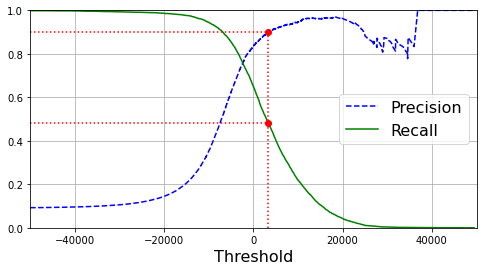

In [104]:
#plot the precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    #b-- is blue dashed dashed
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")    
    
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

#as recall goes up, precision may sometimes go down
#high threshold has high precision and low recall
#low threshold has high recall but low precision


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

#find the threshold required for 90% precision (y axis)
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

#just for graph styling
plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

In [105]:
#find the threshold required for 90% precision (y axis) cont.
#find the index of the 90% precision max value, want the first case that is True
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

#make prediction on training set where the y scores are greater than the threshold for 90%
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [106]:
from sklearn.metrics import precision_score, recall_score
#check the predictions precision and recall values if it did the 90% precision classifier correctly
print("Precision score: ", precision_score(y_train_5, y_train_pred_90)) #is correct
print("Recall score: ", recall_score(y_train_5, y_train_pred_90))

Precision score:  0.9000345901072293
Recall score:  0.4799852425751706


<h3>The Receiver Operating Characteristic (ROC) Curve</h3>

In [107]:
#ROC plots true postive rate (recall) against false positive rate
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

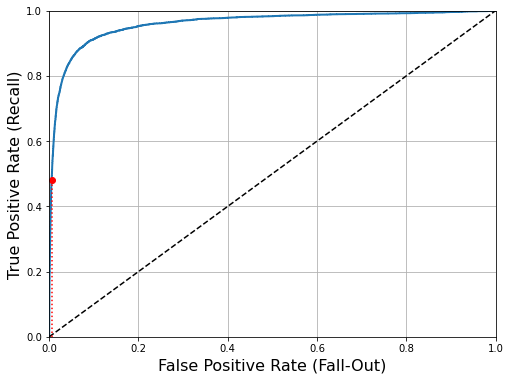

In [108]:
#taken from solution as the code is not provided in the book
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)#call the func
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown

plt.show()

#higher the recall, higher the false positives produced
#dashed line represents ROC curve of a purely random classifier, want to stay away as far as possible from the line
#go towards the top left like this one

In [109]:
#compare classifiers by measuring the AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<h3>Train Another Classifier (Random Forest Classifier) and Compare to SGD Classifier<h3>

In [110]:
#random forest does not have decision function so we use predict_proba instead
from sklearn.ensemble import RandomForestClassifier

#make instance of random forest classifier, set the state to have reproducible results
forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

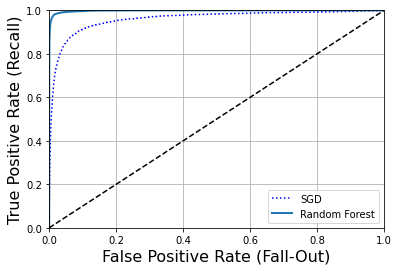

In [111]:
#plot both curves to see how they compare
#roc curve can be given class probabilities instead of scores
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

#random forest is better, farther from the purely random classifier

In [112]:
#check the roc AUC score as well to see if random forest is better
roc_auc_score(y_train_5, y_scores_forest) #it is infact better, the SGD has 0.96

0.9983436731328145

<h2>Multiclass Classification</h2>

<h3>Support Vector Machine Classifier</h3>

In [113]:
#sklearn detects when we try to use a binary classification algo for multiclass classification task and 
#automatically runs OvR or OvO depending on algorithim

#using Support Vector Machine classifier
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5, all classes
svm_clf.predict([some_digit])

#does OvO

array([5], dtype=uint8)

In [114]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores #some digit is '5' which is the highest score of 9.3

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [115]:
#can specify sklearn to use OvO or OvR explicitly rather than it deciding itself
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC()) #we pass the SVC into ctor of OvO or OvR
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

len(ovr_clf.estimators_)


10

<h3>SGD Classifier</h3>

In [116]:
#similar steps to train as before
sgd_clf.fit(X_train, y_train) #fit
sgd_clf.predict([some_digit]) #predict '5'

#uses OvR under the hood

array([3], dtype=uint8)

In [117]:
#check the score of '5' to see how well it did
sgd_clf.decision_function([some_digit])

#most of the scores are negative which is good, the 5th index is '5' and it has a high score which is good as well


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [118]:
#3 was a little high, classifer should be evaluated
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
#decent accuracy, can scale the inputs to get higher accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

<h2>Error Analysis</h2>

In [ ]:
#improve model (SGD) by analyzing the types of errors its making
#check confusion matrix
#using sgd classifier, the scaled data, 3 folds
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
#plot the image to see a better representation
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

#the light diagonal represents the number itself, ex 5 is row (class) 5 col (predict class) 5, however its a little darker

#this means either there isnt enough data for 5 or classifier is not performing as well on 5
# *outputs were taking too long*

<h2>Multilabel Classification</h2>

<h3>K Nearest Neighbors Classifier</h3>

In [ ]:
#goal is to have a classifier that can detect if a number is large (>=7) and if its odd
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) #large nums
y_train_odd = (y_train % 2 == 1) #odd nums
y_multilabel = np.c_[y_train_large, y_train_odd] #creats a multilabel array which has the 2 target labels for each image

#instance of KNN which SUPPORTS multilabel classification
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
#make prediction for '5'
knn_clf.predict([some_digit])

#false for large number and true for odd number

In [ ]:
#evaluate the classifier, metric can be the F1 score across all labels
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

<h2>Multioutput Classification</h2>

In [ ]:
#going to try to remove noise from an image
#since each label is a pixel (multilabel) and each label can have a value of 0-255, it is multioutput classification system

#going to make images noisy using random ints
noise = np.random.randint(0, 100, (len(X_train), 784))

#modify training set
X_train_mod = X_train + noise

#modify test set
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

#these are not noisy images
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
#func to plot a digit
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
#check images now
plt.subplot(121); plot_digit(X_test_mod[0]) #noisy
plt.subplot(122); plot_digit(y_test_mod[0]) #not noisy

plt.show()

In [ ]:
#train classifier using KNN
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])

#lets see the cleaned image
plot_digit(clean_digit) #cleaned!